## Homework 3

* sklearn.datasets sınıfında "make_classification" fonksiyonunu kullanarak veri kümesi oluşturun. Tek etiket (y) 9 özellik (X) ile 10000 örnek oluşturun. Ayrıca şu parametreleri kullanın: 
    * `n_informative` = 4
    *  `class_sep` = 2
    * `random_state` = 18
* Ham veriyi inceleyin ve analiz edin.
* Sınıflandırma (classification) için ön işlem yapın.
* Veri kümenizi eğitim ve test alt kümlerine ayırın (eğitim için 0.7 ve test için 0.3 oran olacak şekilde).
* Karar Ağacı ve XGBoost Algoritmasını farklı hiperparametrelerle deneyin. (GridSearchCV kullanabilirisiniz.)
* Sonucunuzu hem eğitim hem de test setinde değerlendirin. Herhangi bir yetersiz uyum (underfitting) veya aşırı uyum (overfitting) sorunu olup olmadığını analiz edin ve yorumlayın.

## İçindekiler:
* [1. Veri Ön İşleme ve Keşifçi Veri Analizi](#)
 * [1.1 Veri](#)
 * [1.2 Yinelenen/Eksik Veri](#)
 * [1.3 Keşifçi Veri Analizi](#)
 * [1.4 Aykırı Değerler](#)
 * [1.5 Eğitim ve Test Verilerinin Ayrılması](#)
* [2. Model](#)
  * [2.1 DesicionTreeClassifier](#)
  * [2.2 XGBoostClassifier](#)
* [3. Sonuç](#)



---



# 1. Veri Ön İşleme ve Keşifçi Veri Analizi

In [ ]:
# Gerekli kitaplıkları içe aktarın.

In [51]:
from sklearn.datasets import make_classification
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, f1_score
import matplotlib.pyplot as plt
from scipy import stats
import pickle
print('Libraries are imported')

Libraries are imported


## 1.1 Veri 

In [ ]:
# Sklearn'de make_classification fonksiyonunu kullanarak veri kümesi oluşturun.
# Pandas veri çerçevesine dönüştürün.

In [5]:
X,y = make_classification(n_samples=10000, n_features=9, n_informative=4, class_sep=2, random_state=18)

In [6]:
df = pd.DataFrame(data=X, columns=["feat"+str(i) for i in range(1,10)])

In [7]:
df["output"] = y

In [8]:
df.head()

,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,output
0,3.290489,-0.411827,-0.600695,-4.250619,-0.209376,1.019036,-5.717909,-0.179226,-0.914161,0
1,-0.543413,-3.782512,0.390637,0.023942,2.010453,1.185315,1.218147,0.007708,-0.957374,0
2,-2.697898,-3.862467,-0.407272,-0.704430,2.803621,2.080082,1.416647,0.583622,1.332092,1
3,1.051777,-3.129374,-0.499094,0.575599,-0.894801,1.997441,1.938695,-0.113648,0.882476,0
4,2.913780,2.582148,-1.755320,-2.224739,-5.067421,2.062468,-2.614919,-1.154300,0.303457,0


In [9]:
df.iloc[:,:-1].describe()

,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.000742,-1.002711,0.001397,-1.018837,-0.984852,2.015345,0.000921,0.008026,0.004308
std,2.393360,2.156767,1.007745,1.785009,3.711534,1.316801,2.213916,0.999628,0.994603
min,-6.710074,-6.880651,-3.548938,-6.317542,-16.711622,-2.791869,-6.808080,-3.714038,-3.633721
25%,-1.981640,-2.491544,-0.688496,-2.381084,-3.393934,1.151817,-1.991508,-0.664733,-0.670409
50%,-0.078133,-1.520075,-0.010870,-1.197160,-0.401644,2.005485,0.206321,-0.002433,-0.004627
75%,1.994817,0.144942,0.692158,0.665134,1.467977,2.886579,1.999211,0.675401,0.680110
max,8.235676,7.081111,3.738392,3.778696,11.731977,6.911073,4.997483,3.995229,3.845220


## 1.2 Eksik Veri/Yinelenen Veri

In [ ]:
# Yinelenen satırları ve eksik verileri kontrol edin.

In [10]:
df.duplicated().sum() #no duplicates

0

In [11]:
df.isnull().sum() #no null

feat1     0
feat2     0
feat3     0
feat4     0
feat5     0
feat6     0
feat7     0
feat8     0
feat9     0
output    0
dtype: int64

## 1.3 Keşifçi Veri Analiz

In [ ]:
# Her özellik için verileri görselleştirin (pairplot, distplot etc.).

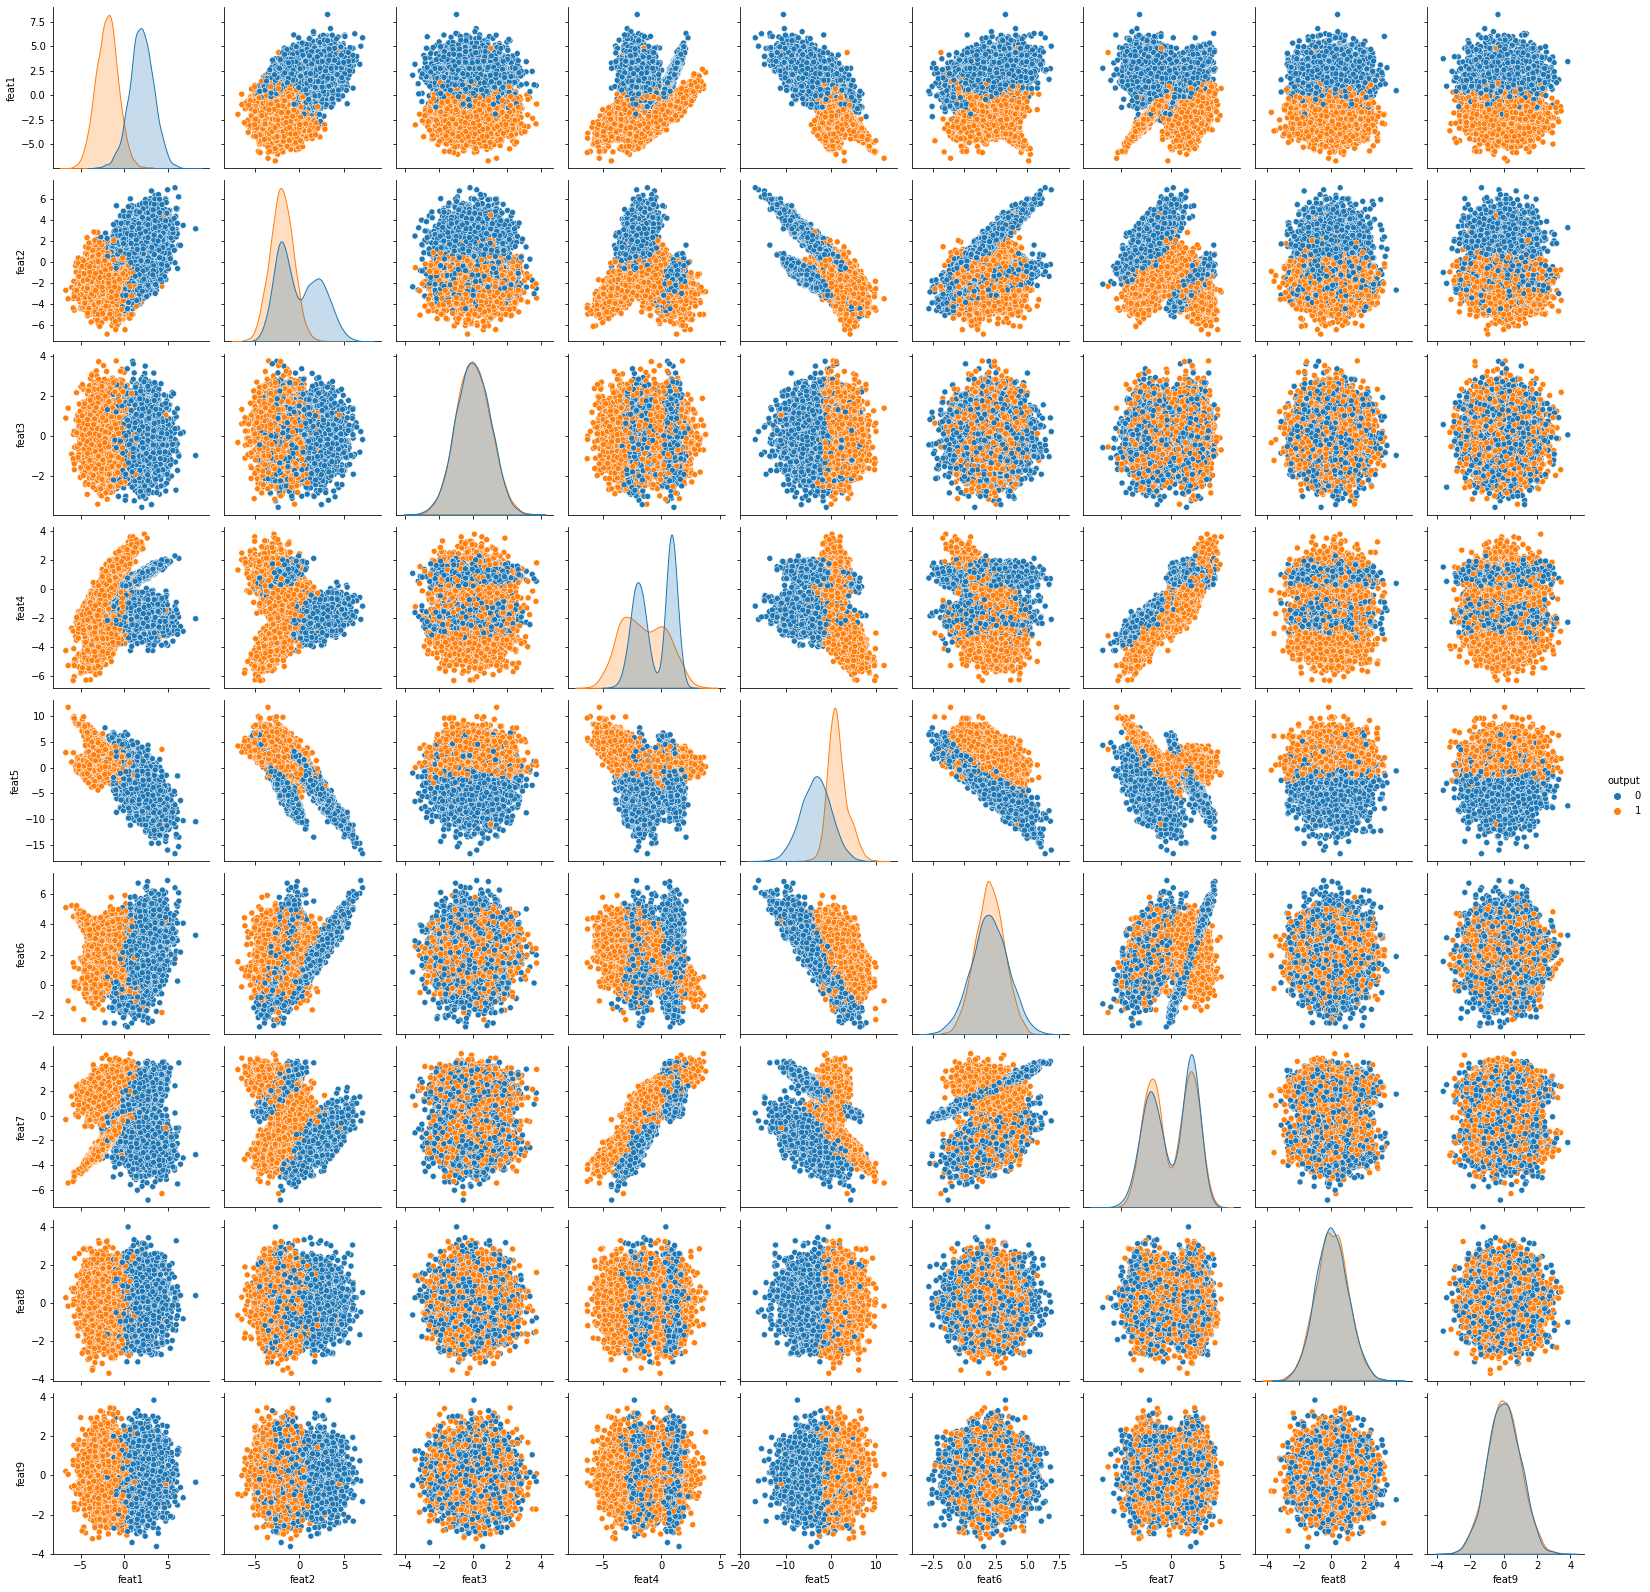

In [22]:
sns.pairplot(df, hue="output")

Scatterplot girafiklerine göre, feat1,  0 ve 1 output değerlerini ayıran en güçlü özelliktir. Bir diğer güçlü özellik feat5'tir.

In [ ]:
# Korelasyon matrisi çizin.

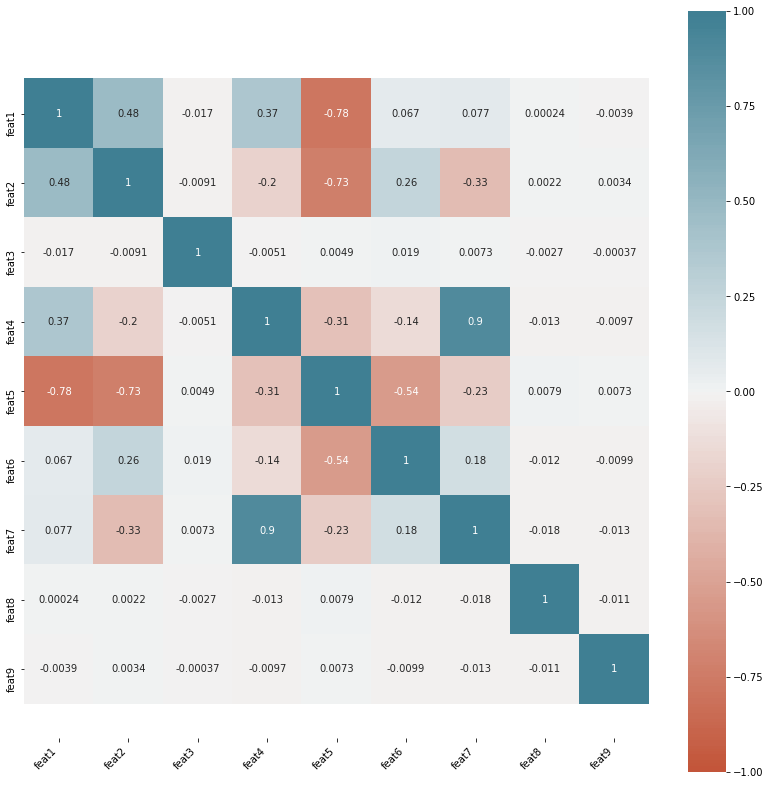

In [29]:
corr = df.iloc[:,:-1].corr()

plt.figure(figsize=(14, 14))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, annot = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_ylim(len(corr)+0.5, -0.5);

Korelasyon matrisinden, feat4 ve feat7 arasında, korelasyon değeri, 0.9. 1 e çok yakın olduğundan güçlü bir pozitif korelasyon olduğuna işaret ediyor.

## 1.4 Aykırı Değerler

In [ ]:
# Aykırı değerleri işleyin (IsolationForest, Z-score, IQR kullanabilirsiniz)

Aykırı değerlerin gözlenmesi için aşağıdaki boxplot grafikler oluşturuldu.
feat2,feat3,feat5,feat8 ve feat9 da aykırı değerler olduğu görülüyor

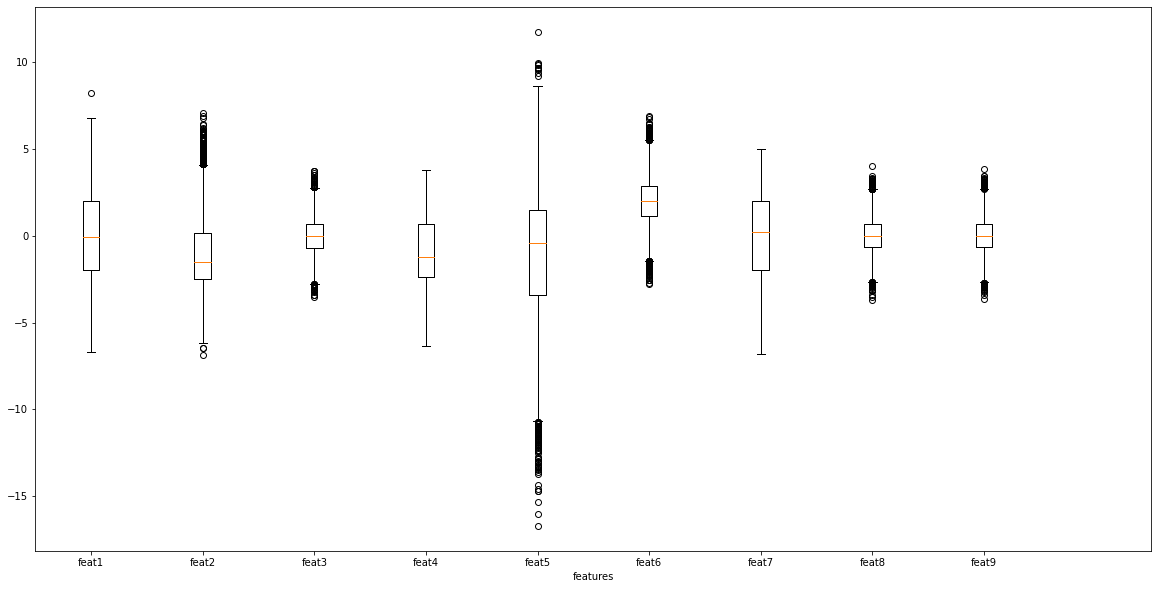

In [108]:
x = df
labellist = list(df.columns[:-1])
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(111)
for i in range(9):
    ax.boxplot(x.iloc[:,i].values, positions = [i])
ax.set_xlim(-0.5, 9.5)
plt.xlabel("features")
plt.xticks(np.arange(len(df.iloc[:,:-1].columns)), df.iloc[:,:-1].columns)
plt.show()

In [30]:
df_X = df.iloc[:,:-1] #yalnızca bağımsız değişkenleri bırak, bağımsız değişken binary (0-1) olduğundan aykırı veri tespitinde yer almasına gerek yok

In [31]:
df_X = pd.DataFrame(df_X,columns=df.iloc[:,:-1].columns)

1. Methos IQR

In [32]:
Q1 = df_X.quantile(0.25)
Q3 = df_X.quantile(0.75)
IQR = Q3 - Q1

In [33]:
alt_sinir = Q1- 1.5*IQR
ust_sinir = Q3 + 1.5*IQR

In [215]:
alt_sinir

feat1    -7.946325
feat2    -6.446272
feat3    -2.759477
feat4    -6.950411
feat5   -10.686802
feat6    -1.450325
feat7    -7.977587
feat8    -2.674934
feat9    -2.696187
dtype: float64

In [216]:
ust_sinir


feat1    7.959502
feat2    4.099670
feat3    2.763139
feat4    5.234461
feat5    8.760845
feat6    5.488721
feat7    7.985290
feat8    2.685601
feat9    2.705888
dtype: float64

In [34]:
outliers = np.where((df_X < alt_sinir) | (df_X > ust_sinir))[0] #altsınırdan küçük ve üstsınırdan büyük verilere sahip satırlar outlier olarak sınıflandırılır

In [221]:
print("Scaling ile tespit edilen outlier sayısı {}".format(len(outliers)))

Scaling ile tespit edilen outlier sayısı 593


IQR methoduna göre 593 aykırı değer bulundu.

IQR Metonuda göre aykırı değerleri çıkarılması

In [36]:
df_cleaned =  df.drop(outliers,axis = 0).reset_index(drop = False) #df_cleaned adında aykırı değerlerden arındırılmış yeni DataFrame oluşturuldu

In [44]:
df_cleaned.drop("index",inplace=True, axis=1)

## 1.5 Eğitim ve Test verilerinin Ayrılması

In [ ]:
# Veri kümesini eğitim ve test verisetlerine ayırın.

In [62]:
X = df_cleaned.iloc[:,:-1]
y = df_cleaned.iloc[:,-1]

In [63]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

# 2. Model

## 2.1 DecisionTreeClassifier

In [ ]:
# Karar Ağacını içe aktarın, farklı hiperparametreleri deneyerek algoritmayı ayarlayın. (hyperpara)

In [64]:
params = {"max_depth": range(1,10),
            "min_samples_split" : list(range(2,50)) }  #hyperparameter seçeneklerinin sözlük yapısında oluşturulması

In [65]:
dtc = DecisionTreeClassifier() #karar ağacı modeli

In [91]:
dtc_cv = GridSearchCV(dtc,params,cv=10, n_jobs = -1, verbose = 2) #Cross validation modelinin cv=10 folda göre oluşturulması

In [92]:
dtc_cv.fit(X_train, y_train) #Crossvalidation ile hyperparameter seçeneklerine göre eğitim verisi ile modelin fit edilmesi

Fitting 10 folds for each of 432 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1112 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 2736 tasks      | elapsed:   57.1s
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed:  2.0min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': range(1, 10),
                         'm

In [93]:
dtc_cv.best_params_ #crossvalidation ile bulunan best hyperparameter seçenekleri

{'max_depth': 9, 'min_samples_split': 21}

In [94]:
dtc_tuned = DecisionTreeClassifier(max_depth= 9, min_samples_split= 21) #modelin best hyperparameter seçenekleri ile oluşturulması, fit edilmesi

In [95]:
dtc_tuned.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=21,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
# Öznitelik önemlerini (feature importances) görselleştirin.

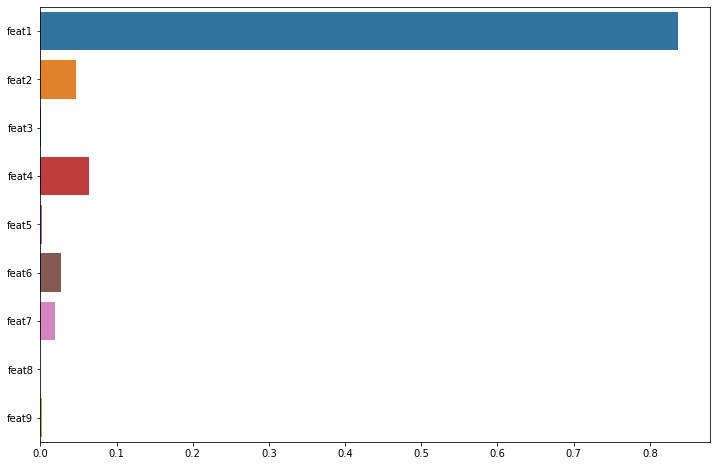

In [96]:
#Feature Importance
plt.figure(figsize=(12, 8))
importance = dtc_tuned.feature_importances_
sns.barplot(x=importance, y=X.columns)
plt.show()

In [ ]:
# Hata matrisini oluşturun ve accuracy, recall, precision ve f1-score değerlerini hesaplayın.

In [97]:
# Classification Report

pred = dtc_tuned.predict(X_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1368
           1       0.99      0.97      0.98      1484

    accuracy                           0.98      2852
   macro avg       0.98      0.98      0.98      2852
weighted avg       0.98      0.98      0.98      2852



In [98]:
# Metrics
print("Precision = {}".format(precision_score(y_test, pred)))
print("Recall = {}".format(recall_score(y_test, pred)))
print("Accuracy = {}".format(accuracy_score(y_test, pred)))
print("F1 Score = {}".format(f1_score(y_test, pred)))

Precision = 0.9863201094391245
Recall = 0.9716981132075472
Accuracy = 0.9782608695652174
F1 Score = 0.9789545145960624


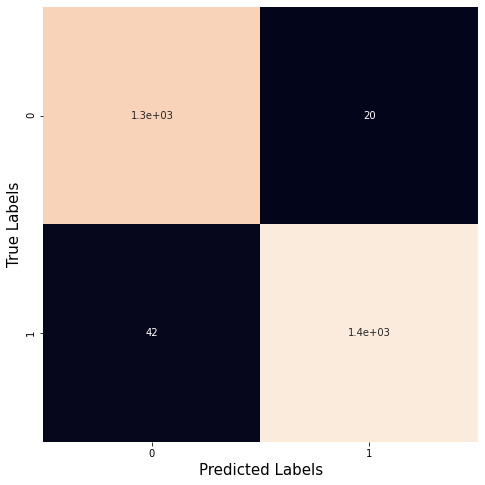

In [99]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(12, 8))
ax =sns.heatmap(cm, square=True, annot=True, cbar=False)
ax.set_xlabel('Predicted Labels',fontsize = 15)
ax.set_ylabel('True Labels',fontsize = 15)
plt.show()

## 2.2 XGBoostClassifier

In [ ]:
# XGBoostClassifier'ı içe aktarın, farklı hiperparametreleri deneyerek algoritmayı ayarlayın.

In [78]:
gbm_params = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,3),
    'learning_rate': [0.00001,0.001,0.01,0.1],
    'n_estimators': [10,200,210,500,1000]
    
}

In [79]:
gbm = XGBClassifier()

In [80]:
gbm_cv = GridSearchCV(gbm,gbm_params,cv=3, n_jobs = -1, verbose = 2)

In [81]:
gbm_cv_model = gbm_cv.fit(X_train,y_train)

filename = 'finalized_model.sav'
pickle.dump(gbm_cv_model, open(filename, 'wb'))


Fitting 3 folds for each of 160 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 14.2min finished


In [82]:
gbm_cv_model.best_params_


{'learning_rate': 0.1,
 'max_depth': 7,
 'min_child_weight': 1,
 'n_estimators': 1000}

In [83]:
gbm_tuned = XGBClassifier(learning_rate= 0.1,max_depth= 7,min_child_weight= 1,n_estimators= 1000)
gbm_tuned.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# Öznitelik önemlerini (feature importances) görselleştirin.

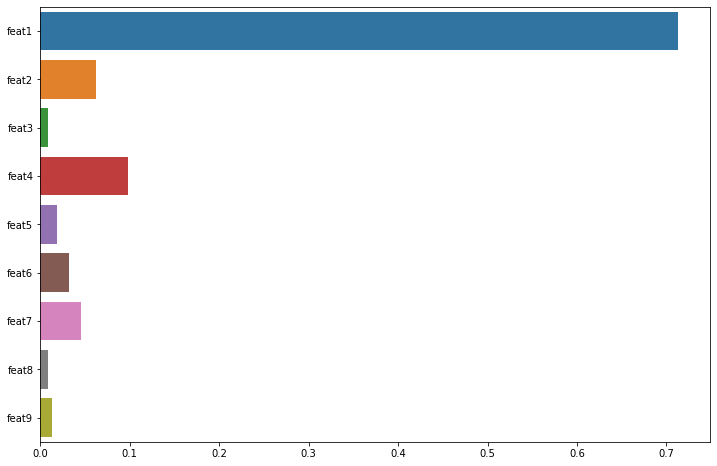

In [84]:
#Feature Importance
plt.figure(figsize=(12, 8))
importance = gbm_tuned.feature_importances_
sns.barplot(x=importance, y=X.columns)
plt.show()

In [ ]:
# Hata matrisini oluşturun ve accuracy, recall, precision ve f1-score değerlerini hesaplayın.

In [85]:
# Classification Report

pred_g = gbm_tuned.predict(X_test)
print(classification_report(y_test,pred_g))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1368
           1       0.99      0.99      0.99      1484

    accuracy                           0.99      2852
   macro avg       0.99      0.99      0.99      2852
weighted avg       0.99      0.99      0.99      2852



In [86]:
# Metrics
print("Precision = {}".format(precision_score(y_test, pred_g)))
print("Recall = {}".format(recall_score(y_test, pred_g)))
print("Accuracy = {}".format(accuracy_score(y_test, pred_g)))
print("F1 Score = {}".format(f1_score(y_test, pred_g)))

Precision = 0.9899125756556826
Recall = 0.9919137466307277
Accuracy = 0.9905329593267882
F1 Score = 0.9909121507909795


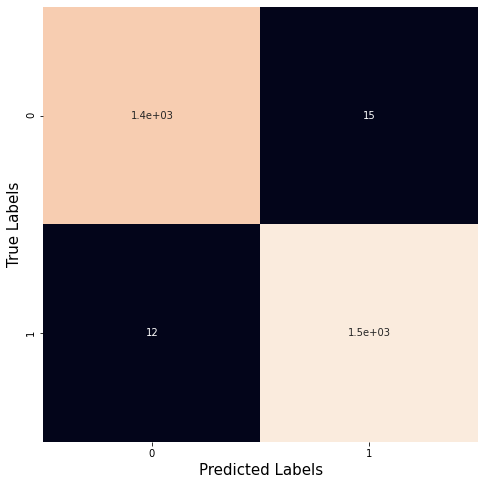

In [87]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred_g)
plt.figure(figsize=(12, 8))
ax =sns.heatmap(cm, square=True, annot=True, cbar=False)
ax.set_xlabel('Predicted Labels',fontsize = 15)
ax.set_ylabel('True Labels',fontsize = 15)
plt.show()

# 3. Sonuç

In [ ]:
# Sonucunuzu değerlendirin ve veri setimiz için en iyi performans gösteren algoritmayı seçin.

Sonuçlara göre hem DesicionTreeClassifier ve XGBoostClassifier modelleri oldukça başarılıdır. XGBoostClassifier,  tüm evaluation metric değerlerine göre daha yüksek sonuçlar elde etmiştir. Presicion oranları çok yakındır. FN sayısı ise DesicionTreeClassifier(FN:40) da XGBoostClassifier (FN:12)'a göre çok daha fazladır, bu da Recall değerlerindeki farkdan da gözleniyor. 

Sonuçlara göre en iyi performans gösteren algoritma, **XGBoostClassifier**'dır.

**XGBoostClassifier:**

Precision = 0.9899125756556826
Recall = 0.9919137466307277
Accuracy = 0.9905329593267882
F1 Score = 0.9909121507909795

**DesicionTreeClassifier:**

Precision = 0.9863201094391245
Recall = 0.9716981132075472
Accuracy = 0.9782608695652174
F1 Score = 0.9789545145960624